# MSD 2019 Final Project

## A replication and extension of "Automated Hate Speech Detection and the Problem of Offensive Language" by Thomas Davidson, Dana Warmsley, Michael Macy, Ingmar Weber4 Published in ICWSM 2017.

### Ketakee Nimavat (kkn2112), Chandana priya (cg3111), Ankit Peshin (ap3772) 

# Introduction

## Motivation

The main focus of this paper was  the differentiation between hate speech and offensive speech. Drawing from the definitions of the paper, hate speech is  language that is used to expresses hatred towards a targeted group or is intended to be derogatory, to humiliate, or to insult the members of the group. The targets usually are a minority group or people with disadvantage. In extreme cases, this hate speech can sometimes insinuate violence.  On the other hand, offensive speech is defined as  the language of sexisim and obscene comments made by one person to another. 

Because of its seriousness, many countries like France, UK, Canada pose legal implications/charges to those found guilty of using hate speech. These laws usually extends to TV, media and the internet. Given this scenario, it becomes necessary to distinguish between the two highly similar languages. The paper mainly concentrates on this specific issue. The ground truth for this analysis is collected via crowdsourcing where each tweet/text is classified as hate speech, offensive or neither. The paper also discusses about when this distinction is not feasible.


## Replication & Implementation Overview

To reproduce the results from the paper, we used the same dataset provided by the authors, containing about 25k sample tweets and their corresponding labels assigned via crowdsourcing. Each tweet had mentions, retweets and/or hashtags. To have a count on the number of mentions and urls and to identify if it was a retweet, we replaces any url sequence with ‘URLHERE’, @_name__ with ‘MENTIONHERE’ and check if there was a ‘rt’ (retweet) to indicate if it was a retweet. 

We later cleaned the tweets to remove special characters and tokenize the words. We also removed stopwords from the tweets using the NLTK library. Once we have the tweets tokenized to words, we used the stemming technique to identify tokens by their root words. The NLP toolkit provides built in packages for stemming words with many variants. We’ve used PorterStemmer in the implementation.  Furthermore, the Part-of-Speech (POS) tags for  unigrams, bigrams, and trigrams are computed. To capture the quality of each tweet we use modified Flesch-Kincaid scores and also calculated the sentiment score associated with each tweet.

# Steps for replication


## Data 
The data corpus we used for replicating the results from "Automated Hate Speech Detection and the Problem of Offensive Language" is the original dataset, provided by the author. This data has been generated by crowdsourcing various tweets with their corresponding labels. This forms the ground truth for our analysis.



In [0]:
import pandas as pd

In [0]:
import numpy as np

In [4]:
!pip install vaderSentiment

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
import nltk
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.sparse import hstack
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from nltk import word_tokenize,sent_tokenize
from gensim import corpora
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt


### Loading the data

In [0]:
df_train = pd.read_csv("/data/labeled_data.csv")[["tweet","class"]]

In [7]:
df_train.head()


,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


Here we take equal data from all classes, one class has a little bit less data but that is a minor imbalance that can be tolerated

In [8]:
X_train = df_train[df_train['class']==0]["tweet"]
X__train = df_train[df_train['class']==1]["tweet"][:1000]
X_train = X_train.append(X__train)
X__train = df_train[df_train['class']==2]["tweet"][:1000]
X_train = X_train.append(X__train)
y_train = df_train[df_train['class']==0]["class"]
y_train = y_train.append(df_train[df_train['class']==1]["class"][:1000])
y_train = y_train.append(df_train[df_train['class']==2]["class"][:1000])
len(X_train)

3430

In [9]:
len(y_train)

3430

## Feature Enginerring 
Since we are dealing with unstructured data, we used preprocessing, stemming, vectorization, POS tag and sentiment scores to consider right words (tokens) to the features set along with some summary statistics like number of number of words, characters, number of times a URL was sited, number of times a tweet was retweeted, number of mentions etc.


1. Lowercase
2. Stem
3. bigram, unigram, trigram features, weighted by its tfidf
4. POS tag
5. FK Grade level
6. FK reading ease score
7. sentiment scores

8. binary indicators for: hashtags, mentions, retweets, urls
9. count indicatiors for :hashtags, mentions, retweets, urls
10. number of characters
11. numbers of words
12. number of syllables



In [10]:
nltk.download("stopwords")
from nltk.stem.porter import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt","RT"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()

def preprocess(text_string):
    
    #Lowercase string
    text_string=text_string.lower()
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    
    #Stem it
    tweet = " ".join(re.split("[^a-zA-Z]*", parsed_text)).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens
  
  
def pos_tag_seq(tokens):
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    return tag_str
  
  

In [0]:
def join_sent(l):
  return " ".join(l)

In [0]:
df_train=pd.DataFrame(X_train)

In [0]:
df_train.columns=["tweet"]

In [15]:
df_train.head()

,tweet
85,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1..."
89,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ..."
110,"""@DevilGrimz: @VigxRArts you're fucking gay, b..."
184,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL..."
202,"""@NoChillPaz: ""At least I'm not a nigger"" http..."


In [16]:
s_train=df_train['tweet'].apply(preprocess)

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [0]:
s_tr=s_train.apply(join_sent)

In [18]:
nltk.download('averaged_perceptron_tagger')
t_tr=s_train.apply(pos_tag_seq)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [0]:
vectorizer = TfidfVectorizer(
    preprocessor=None,
    lowercase=False,
    ngram_range=(1, 3),
    use_idf=True,
    smooth_idf=False,
    norm=None,
    stop_words=stopwords,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [0]:
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [0]:
tfidf_tr = vectorizer.fit_transform(s_tr).toarray()

vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()}

In [0]:
pos_tr = pos_vectorizer.fit_transform(t_tr).toarray()

pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [0]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
sentiment_analyzer = VS()


In [0]:
def get_sentiment(text):
  sentiment = sentiment_analyzer.polarity_scores(text)
  return sentiment

#   return sentiment["neg"], sentiment["pos"], sentiment["neu"]

In [0]:
df_train["sent"]=df_train["tweet"].apply(get_sentiment) 

In [26]:
df_train.head()

,tweet,sent
85,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
89,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ...","{'neg': 0.187, 'neu': 0.813, 'pos': 0.0, 'comp..."
110,"""@DevilGrimz: @VigxRArts you're fucking gay, b...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
184,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL...","{'neg': 0.254, 'neu': 0.746, 'pos': 0.0, 'comp..."
202,"""@NoChillPaz: ""At least I'm not a nigger"" http...","{'neg': 0.232, 'neu': 0.488, 'pos': 0.28, 'com..."


In [0]:
foo_tr = lambda x: pd.Series([x["pos"],x["neg"],x["neu"]])
rev_tr = df_train['sent'].apply(foo_tr)


In [0]:
rev_tr.columns=["pos","neg","neu"]

In [29]:
rev_tr.head()

,pos,neg,neu
85,0.00,0.000,1.000
89,0.00,0.187,0.813
110,0.00,0.000,1.000
184,0.00,0.254,0.746
202,0.28,0.232,0.488


### Binary count for URL https mentions etc 
we replace each URL expression with "URLHERE" and each '@....' with a  "MENTIONHERE" so that we can later keep track of the number of occurences of these terms 

In [0]:
def return_cont(parsed_text):
  return(parsed_text.count('urlher'),parsed_text.count('mentionher'),parsed_text.count('hashtagher'))

In [0]:
df_train["counts"]=s_tr.apply(return_cont) 

In [32]:
df_train["counts"].head()

85     (0, 3, 0)
89     (0, 2, 0)
110    (1, 2, 1)
184    (1, 1, 0)
202    (1, 1, 0)
Name: counts, dtype: object

In [0]:
foo = lambda x: pd.Series([x[0],x[1],x[2]])
mention_counts_tr = df_train['counts'].apply(foo)


In [34]:
mention_counts_tr.head()

,0,1,2
85,0,3,0
89,0,2,0
110,1,2,1
184,1,1,0
202,1,1,0


### FKRA and Flesch and number of syllables etc

FKRA is our go to solution for English syntax parsing, and some additional features like number of syllables, characters,words, etc. should give greater insight.

In [35]:
!pip install textstat
from textstat.textstat import *

In [0]:
def get_other_features(text):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    words = re.sub(mention_regex, '', parsed_text)
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(text)
    num_terms = len(text.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_terms, num_words,
                num_unique_terms]
    return features
    
  

In [0]:
other_feats_tr=df_train["tweet"].apply(get_other_features)

In [38]:
other_feats_tr.head()

85         [9.2, 34.62, 6, 1.9997, 18, 5, 3, 3]
89        [6.8, 67.76, 18, 1.5, 59, 13, 12, 10]
110    [9.1, 49.55, 19, 1.7272, 76, 13, 11, 11]
184    [5.2, 84.46, 19, 1.2666, 78, 15, 15, 15]
202        [2.3, 94.3, 11, 1.2222, 38, 9, 9, 9]
Name: tweet, dtype: object

In [0]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars","num_terms", "num_words", "num_unique_words"]

In [0]:
foo = lambda x: pd.Series(elem for elem in x)
of_counts_tr = other_feats_tr.apply(foo)

In [41]:
of_counts_tr.head()

,0,1,2,3,4,5,6,7
85,9.2,34.62,6.0,1.9997,18.0,5.0,3.0,3.0
89,6.8,67.76,18.0,1.5000,59.0,13.0,12.0,10.0
110,9.1,49.55,19.0,1.7272,76.0,13.0,11.0,11.0
184,5.2,84.46,19.0,1.2666,78.0,15.0,15.0,15.0
202,2.3,94.30,11.0,1.2222,38.0,9.0,9.0,9.0


In [0]:
of_counts_tr.columns=other_features_names

In [43]:
of_counts_tr.head()

,FKRA,FRE,num_syllables,avg_syl_per_word,num_chars,num_terms,num_words,num_unique_words
85,9.2,34.62,6.0,1.9997,18.0,5.0,3.0,3.0
89,6.8,67.76,18.0,1.5000,59.0,13.0,12.0,10.0
110,9.1,49.55,19.0,1.7272,76.0,13.0,11.0,11.0
184,5.2,84.46,19.0,1.2666,78.0,15.0,15.0,15.0
202,2.3,94.30,11.0,1.2222,38.0,9.0,9.0,9.0


In [44]:
df_train.drop([ "sent","counts"], axis=1)

,tweet
85,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1..."
89,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ..."
110,"""@DevilGrimz: @VigxRArts you're fucking gay, b..."
184,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL..."
202,"""@NoChillPaz: ""At least I'm not a nigger"" http..."
204,"""@NotoriousBM95: @_WhitePonyJr_ Ariza is a sna..."
219,"""@RTNBA: Drakes new shoes that will be release..."
260,"""@TheoMaxximus: #GerrysHalloweenParty http://t..."
312,"""@ashlingwilde: @ItsNotAdam is bored supposed ..."
315,"""@bigbootybishopp: @white_thunduh lassen cc , ..."


In [45]:
for elem in [pd.DataFrame(tfidf_tr),pd.DataFrame(pos_tr),rev_tr,mention_counts_tr, of_counts_tr]:
  print(len(elem))


3430
3430
3430
3430
3430


In [0]:
# x_train=np.column_stack([tfidf,pos,rev,mention_counts, other_feats])
x_train=np.concatenate([pd.DataFrame(tfidf_tr),pd.DataFrame(pos_tr),rev_tr,mention_counts_tr, of_counts_tr],axis=1 )
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)


In [47]:
print(len(x_train))

2744


In [48]:
print(len(y_train))

2744


## Model

To replicate the model, we passed the parameters mentioned in the paper for the classifier to see if we can reproduce the results. The parameters are L2 regularization on a LogisticRegression model after doing dimensioin reduction via feature selection.

In [80]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import numpy as np
pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="l1", C=0.01))),
        ('model', LogisticRegression(class_weight='balanced',penalty='l2'))])
param_grid = [{}]
grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(x_train, y_train), 
                           verbose=2)
model = grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ................................................. , total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ................................................. , total=   0.2s
[CV]  ................................................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ................................................. , total=   0.3s
[CV]  ................................................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ................................................. , total=   0.2s
[CV]  ................................................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] ................................................. , total=   0.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [0]:
y_preds = model.predict(x_test)

In [82]:
model.best_score_

0.7274052478134111

In [83]:
model.cv_results_

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([0.23730369]),
 'mean_score_time': array([0.00467587]),
 'mean_test_score': array([0.72740525]),
 'mean_train_score': array([0.73651688]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.72727273]),
 'split0_train_score': array([0.7461258]),
 'split1_test_score': array([0.72727273]),
 'split1_train_score': array([0.73154057]),
 'split2_test_score': array([0.70437956]),
 'split2_train_score': array([0.73907104]),
 'split3_test_score': array([0.75547445]),
 'split3_train_score': array([0.73315118]),
 'split4_test_score': array([0.72262774]),
 'split4_train_score': array([0.73269581]),
 'std_fit_time': array([0.02594034]),
 'std_score_time': array([0.00180653]),
 'std_test_score': array([0.0163644]),
 'std_train_score': array([0.00546895])}

In [84]:
model.best_params_

{}

# Results and Analaysis

# Precison, Recall and f1-score
By definition, we know that precison is the number of datapoints that are actually true divided over the total number of datapoints predicted true, while recall is the fraction of predicted true datapoints that are actually true. From the below results we can see that precision for the "Hate" class is quite high. This could be because of the intersection of definitions of "Hate" and "Offensive" data/tweets. Thus we can see that there could be a lot of false positives associated with the "Hate" class because of which the the precision value is high. 

We can further notice that the recall value for "Hate" class is the comparitively less. Thus, the fraction of those predicted true over those actually true is low. So in a sense, we have a very picky classifier, which only picks hate tweets when there is a high probability - meaning a lot of hate tweets are also misclassified as for other classes. This is one huge shortcoming of the base model. In essence, our aim was to create a high-recall-low-precision classifier, so that no hate-tweet goes unnoticed. Should we create an automated moderator, any tweets misclassified as hate can definitely be repealed on dispute.

In [85]:
from sklearn.metrics import classification_report
report = classification_report( y_test, y_preds )
print(report)

              precision    recall  f1-score   support

           0       0.83      0.66      0.74       270
           1       0.78      0.78      0.78       218
           2       0.74      0.93      0.82       198

   micro avg       0.78      0.78      0.78       686
   macro avg       0.78      0.79      0.78       686
weighted avg       0.79      0.78      0.78       686



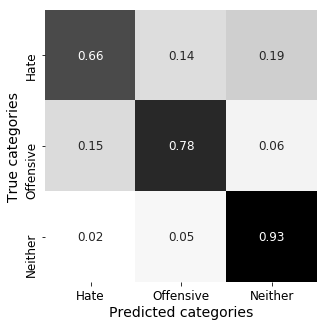

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)


Analyzing the confusion matrix for some interesting trends, we notice that :
- 'Neither' has the highest accuracy and is rarely misclassified.
- Quite understandably, most 'offensive' tweets that are misclassified are assigned to category 'hate'. This is argued in the base paper as well as one of the issues plaguing such classifier that categorize offensive tweets as hate speech.
- Interestingly enough, misclassified hate tweets are more likely to be categorized as 'neither' than as 'offensive'. This is another problem that plagues classifiers that simply identify hate vs non-hate by a few key words.

                B
count  686.000000
mean     1.049563
std      0.823305
min      0.000000
25%      0.000000
50%      1.000000
75%      2.000000
max      2.000000


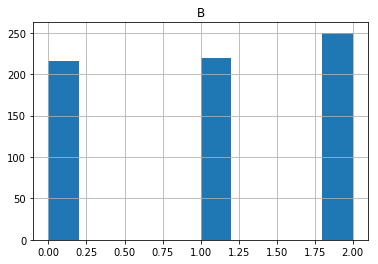

In [88]:
from pandas import read_csv
from matplotlib import pyplot
import pandas as pd
# load results file
results = pd.DataFrame()
results['B'] = y_preds
# descriptive stats
print(results.describe())
# box and whisker plot
# histogram
results.hist()
pyplot.show()

                B
count  686.000000
mean     0.895044
std      0.819866
min      0.000000
25%      0.000000
50%      1.000000
75%      2.000000
max      2.000000


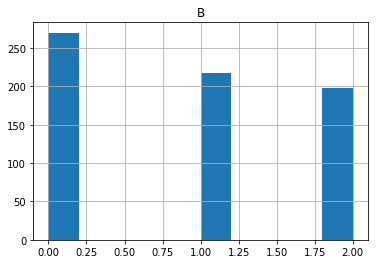

In [89]:
from pandas import read_csv
from matplotlib import pyplot
import pandas as pd
# load results file
results = pd.DataFrame()
results['B'] = y_test
# descriptive stats
print(results.describe())
# box and whisker plot
# histogram
results.hist()
pyplot.show()

As we can observe, while the vast majority of our ground truth labels in test set are 'hate' and the other two have similar counts. This base classifier however tends to predict most observations as 'neutral'.

# Challenges

Given the task, most of the paper was simple to replicate and we were able to do it easily. The major questions that we had to ask at each step were fundamental and weren’t always answered in the paper.
Two of the issues are as follows: 
The authors hadn’t handled data imbalance
Testing was done only in sample
Elaborating upon that:
1. The original data has a major class imbalance. Even the paper states that only 1.5% of the tweets were labelled as “hate speech”. In all our replications, we’ve handled the imbalance by undersampling the data.
2. The authors did cross-validation but while generating predictions, the data passed is only the training data. There is no explicit testing data.
While not challenges, they were just things that we thought could be done differently. In our replication and extension, we have changed it.
Another one of the challenges we faced was finding the right data. Majority of the data sources, especially the ones that pertained to twitter, the data was either highly imbalanced or no longer existed. For example, in https://github.com/ZeerakW/hatespeech , the twitter data we originally intended to replicate, on scraping twitter we found that most of the tweets that the author had labelled as hate were not available. We then moved to another dataset which had the text in it and didn’t require any scraping. It can be found here https://github.com/aitor-garcia-p/hate-speech-dataset
.
Given that we trained on a general hate speech data, we thought it would be interesting to see what it would be like to the performance of the model on another kind of hate.

### Was everything clearly spelled out in the paper? 
The authors did clearly spell out the procedures and the paper was clear and lucid enough.However, we also had to make guesses at multiple places regarding what the authors were doing, especially regarding the data imbalance part, since they hadn’t mentioned dealing with it in the paper, we assumed the results given are on imbalanced data. 
 
### If your results differ from those in the paper, explain how and speculate as to why. 
Our results differ from the authors on multi-class classification, this is primarily because we handled data imbalance.  
We obtained higher precision, accuracy than the paper. We suspect this is because the data was imbalanced in the original code, then on balancing it, since the dataset becomes much much smaller as compared to the original code, the accuracy increased.
Our extensions have shown better performance on the data itself, in multiclass and binary classification, however on transfering the model to another dataset, we found our results dipped. This is probably because the methods and algorithms used are highly dependent on the words itself and not on the underlying meaning of the word.


# Extensions

## Idea

Offense is something that has a very specific individual target and the content is meant to hurt the person. Hate speech on the other hand is derogatory or is intended to either degrade the person.
The authors differentiate between offense and hate speech, however for our extensions, we decided to just find the hate speech from the given texts. The motivation beyond lies in the fact that if implementing something similar in a real world scenario, it would be more useful to detect offensive content. We believe that it is better to misclassify something as hatespeech rather than it be missed altogether since the cost of missing hate speech is higher than the cost of having a human eye go through tweets classified as hate speech. Given the accuracy of the classifier, we thought it would be interesting to ultimately see how applicable the given algorithm is to a real world situation. We hence include the following steps to get to that: 
We decided to see this in three steps:

    1.Do binary classification instead of multiclass classification
    2.Extend the code to another dataset
    3.Use a deep learning method based on word embeddings to reduce keyword based reliance.
    
We elaborate on them below:

    1.Binary class replication We replicate the authors code on a binary class data, in this we merged the classes 1 and 2 (offensive and neutral). The code and the discussion of the results can be found in the “Binary_class_replication.
    2. We extend the code to white supremacy hate speech dataset. The code is in “Train_test_twitter_extension” notebook. We find that although race based hate is a logical subset of the original general hate speech of our base data, the model doesnt generalize well because of its reliance on statistical features
    3. Lastly, we use deep learning based methods to help decrease reliance on word based and statistical features. We used universal word embeddings[https://arxiv.org/abs/1803.11175] This helped us achieve better results on the training data and didn’t require as much time or feature engineering either. We believe working on these using a larger and more general dataset should help achieve a better accuracy over generalized hate and specific hate. The implementation is in the files: “Transfer_learning_binary_classification” and “Transfer_learning_multiclass”.

In conclusion, given the small amount of data, high result metrics was very exciting. However, it also meant we should be cautious about it. One of the things was that we did to see how well the algorithm generalized was to test it on another dataset. Hence, we chose the below dataset: https://github.com/aitor-garcia-p/hate-speech-dataset and applied the author’s idea. We saw that it does not generalize well. This is probably because of the small size of the dataset and the different nature of the two datasets. While the original dataset is a general hatespeech data, we noticed it is skewed towards female hate speech (based on the exploratory data analysis results for most common word,s most common ngrams), our testing data for the second part was skewed towards supremacist hate. 

# Conclusions


We will summarize our conclusions as follows :
- A high recall, low precision (relatively) model would be better than the high-precision low recall model that we have obtained here by replicating the base paper. Our aim is to not miss any hate speech since that is the most important category. Misclassified tweets can be contested with the moderators who will be human.
- Models which associate hate vs non-hate by the presence of strong language do tend to have high accuracies, but also tend to misclassify a lot of terms that aren't necessarily hate speech merely by the presence of strong language.
-Identifying the semantics via pos tagging, fkra, and other feature engineering methods can make our model more generalizable and less dependent on particular words.
- And lastly a recurring issue with hate classifiers is that they tend to classify tweets as less offensive that the human encoders who annotated the dataset. Along with newer approaches, we will see if our extensions are able to overcome these challenges and provide better insights.